# Keras tuner - application to a deeper network (for fun)

The anser it found:

     'n_units1': 128,
     'n_units2': 32,
     'n_units3': 544,
     'n_units4': 992
     
 So wide → narrow → wider → wider
 
 Hmm. Fun!

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kerastuner as kt

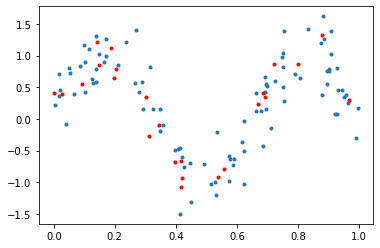

In [20]:
# Cook some simplistic data:
np.random.seed(1)
n_points = 120
x = np.random.uniform(size=n_points)
y = np.sin(x*3*np.pi) + np.random.normal(size=x.shape)/3

ind = list(range(np.round(n_points*0.2).astype(int)))
xtest = x[ind]
ytest = y[ind]
x = x[[i for i in range(n_points) if i not in ind ]]
y = y[[i for i in range(n_points) if i not in ind ]]

plt.plot(x,y,'.');
plt.plot(xtest, ytest, 'r.');

In [21]:
# Custom callback, to see what's happening during the training
# https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print(f"{logs['loss']:0.3}", end=' ')

In [22]:
def make_model_for_tuning(hp):
    
    #scale = [32, 64, 128, 256, 512, 1024]
    n_units1 = hp.Int('n_units1', min_value = 32, max_value = 1024, step = 32)
    n_units2 = hp.Int('n_units2', min_value = 32, max_value = 1024, step = 32)
    n_units3 = hp.Int('n_units3', min_value = 32, max_value = 1024, step = 32)
    n_units4 = hp.Int('n_units4', min_value = 32, max_value = 1024, step = 32)
    # These strings inside are the name for the parameter
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)), # https://www.tensorflow.org/api_docs/python/tf/keras/Input
        tf.keras.layers.Dense(n_units1),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(n_units2),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(n_units3),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(n_units4),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    
    # This is the key line: it defines the tuning space
    learning_rate = hp.Choice('learning_rate', values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
    
    model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['mean_squared_error'])
    return model

#model = make_model((8,89))
#model.summary()

In [24]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(make_model_for_tuning,
                     objective='val_loss', 
                     max_epochs=10,
                     factor=3,
                     directory = 'C:/Temp/temp_keras_tuner_dir',
                     project_name = 'keras_tuner_intro'
                    )  

Some notes on the init above:

* A local dir for `directory` didn't work for me; I suspect that's because the hirerachy of folders + a longish file name became too long for the system to handle it. Switching to a more "root" directory fixed the issue.
* If the optimizer finished running, you cannot run it again with the same `project_name`, and a new set of parameters in the model declaration. It seems that it tries to read the checkpoints, and fails. Either change the `project_name`, or delete the folder to start anew.

In [26]:
# Hyperparameter search

tuner.search(x, y, epochs = 10, 
             validation_data = (xtest, ytest));

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps.get('n_units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.5949 - mean_squared_error: 0.59 - 0s 63ms/step - loss: 0.5825 - mean_squared_error: 0.5825 - val_loss: 0.5194 - val_mean_squared_error: 0.5194
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.6569 - mean_squared_error: 0.65 - 0s 37ms/step - loss: 0.5262 - mean_squared_error: 0.5262 - val_loss: 0.5131 - val_mean_squared_error: 0.5131


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.5284 - mean_squared_error: 0.52 - 0s 58ms/step - loss: 1955774336.0000 - mean_squared_error: 1955774336.0000 - val_loss: 88771424.0000 - val_mean_squared_error: 88771424.0000
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 93016288.0000 - mean_squared_error: 93016288.00 - 0s 12ms/step - loss: 431164928.0000 - mean_squared_error: 431164928.0000 - val_loss: 1296052608.0000 - val_mean_squared_error: 1296052608.0000


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6437 - mean_squared_error: 0.64 - 0s 71ms/step - loss: 930.7397 - mean_squared_error: 930.7397 - val_loss: 314698.8438 - val_mean_squared_error: 314698.8438
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 428036.3125 - mean_squared_error: 428036.31 - 0s 85ms/step - loss: 143201.5000 - mean_squared_error: 143201.5000 - val_loss: 127.5663 - val_mean_squared_error: 127.5663


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.5678 - mean_squared_error: 0.56 - 0s 78ms/step - loss: 20964503552.0000 - mean_squared_error: 20964503552.0000 - val_loss: 1196978688.0000 - val_mean_squared_error: 1196978688.0000
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 1375716608.0000 - mean_squared_error: 1375716608.00 - 0s 14ms/step - loss: 2499440640.0000 - mean_squared_error: 2499440640.0000 - val_loss: 14737355776.0000 - val_mean_squared_error: 14737355776.0000


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6614 - mean_squared_error: 0.66 - 0s 63ms/step - loss: 0.5637 - mean_squared_error: 0.5637 - val_loss: 0.5226 - val_mean_squared_error: 0.5226
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.5783 - mean_squared_error: 0.57 - 0s 40ms/step - loss: 0.5207 - mean_squared_error: 0.5207 - val_loss: 0.5162 - val_mean_squared_error: 0.5162


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.5470 - mean_squared_error: 0.54 - 0s 57ms/step - loss: 0.5662 - mean_squared_error: 0.5662 - val_loss: 0.5395 - val_mean_squared_error: 0.5395
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.5748 - mean_squared_error: 0.57 - 0s 30ms/step - loss: 0.5218 - mean_squared_error: 0.5218 - val_loss: 0.5222 - val_mean_squared_error: 0.5222


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 59ms/step - loss: 1.6228 - mean_squared_error: 1.6228 - val_loss: 0.5613 - val_mean_squared_error: 0.5613
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.5190 - mean_squared_error: 0.51 - 0s 40ms/step - loss: 0.5152 - mean_squared_error: 0.5152 - val_loss: 0.5206 - val_mean_squared_error: 0.5206


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6489 - mean_squared_error: 0.64 - 0s 71ms/step - loss: 1.8396 - mean_squared_error: 1.8396 - val_loss: 0.5335 - val_mean_squared_error: 0.5335
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.4708 - mean_squared_error: 0.47 - 0s 41ms/step - loss: 0.7328 - mean_squared_error: 0.7328 - val_loss: 0.4960 - val_mean_squared_error: 0.4960


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6123 - mean_squared_error: 0.61 - 0s 62ms/step - loss: 1.9440 - mean_squared_error: 1.9440 - val_loss: 0.5277 - val_mean_squared_error: 0.5277
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.3682 - mean_squared_error: 0.36 - 0s 13ms/step - loss: 0.6700 - mean_squared_error: 0.6700 - val_loss: 0.6210 - val_mean_squared_error: 0.6210


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6979 - mean_squared_error: 0.69 - 0s 60ms/step - loss: 35.9459 - mean_squared_error: 35.9459 - val_loss: 60.1323 - val_mean_squared_error: 60.1323
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 68.9489 - mean_squared_error: 68.94 - 0s 32ms/step - loss: 45.3943 - mean_squared_error: 45.3943 - val_loss: 19.1537 - val_mean_squared_error: 19.1537


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.7366 - mean_squared_error: 0.73 - 0s 67ms/step - loss: 1.8697 - mean_squared_error: 1.8697 - val_loss: 0.5197 - val_mean_squared_error: 0.5197
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.4846 - mean_squared_error: 0.48 - 0s 15ms/step - loss: 0.9321 - mean_squared_error: 0.9321 - val_loss: 0.5576 - val_mean_squared_error: 0.5576


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.6805 - mean_squared_error: 0.68 - 0s 69ms/step - loss: 0.5720 - mean_squared_error: 0.5720 - val_loss: 0.5183 - val_mean_squared_error: 0.5183
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 0.6470 - mean_squared_error: 0.64 - 0s 43ms/step - loss: 0.5035 - mean_squared_error: 0.5035 - val_loss: 0.5176 - val_mean_squared_error: 0.5176


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.7566 - mean_squared_error: 0.75 - 0s 65ms/step - loss: 2.4069 - mean_squared_error: 2.4069 - val_loss: 0.5404 - val_mean_squared_error: 0.5404
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.5060 - mean_squared_error: 0.50 - 0s 44ms/step - loss: 0.7827 - mean_squared_error: 0.7827 - val_loss: 0.5393 - val_mean_squared_error: 0.5393


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.5844 - mean_squared_error: 0.58 - 0s 61ms/step - loss: 0.6237 - mean_squared_error: 0.6237 - val_loss: 0.5293 - val_mean_squared_error: 0.5293
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.7560 - mean_squared_error: 0.75 - 0s 38ms/step - loss: 0.5390 - mean_squared_error: 0.5390 - val_loss: 0.5264 - val_mean_squared_error: 0.5264


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.6453 - mean_squared_error: 0.64 - 0s 59ms/step - loss: 0.5961 - mean_squared_error: 0.5961 - val_loss: 0.5287 - val_mean_squared_error: 0.5287
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4062 - mean_squared_error: 0.40 - 0s 37ms/step - loss: 0.5237 - mean_squared_error: 0.5237 - val_loss: 0.5196 - val_mean_squared_error: 0.5196


Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.6138 - mean_squared_error: 0.61 - 0s 63ms/step - loss: 0.6443 - mean_squared_error: 0.6443 - val_loss: 0.5367 - val_mean_squared_error: 0.5367
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.5923 - mean_squared_error: 0.59 - 0s 12ms/step - loss: 0.5210 - mean_squared_error: 0.5210 - val_loss: 0.5831 - val_mean_squared_error: 0.5831


Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.6307 - mean_squared_error: 0.63 - 0s 72ms/step - loss: 0.5247 - mean_squared_error: 0.5247 - val_loss: 0.5596 - val_mean_squared_error: 0.5596
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.6266 - mean_squared_error: 0.62 - 0s 43ms/step - loss: 0.5302 - mean_squared_error: 0.5302 - val_loss: 0.5157 - val_mean_squared_error: 0.5157
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5963 - mean_squared_error: 0.59 - 0s 35ms/step - loss: 0.5184 - mean_squared_error: 0.5184 - val_loss: 0.5107 - val_mean_squared_error: 0.5107
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.4098 - mean_squared_error: 0.40 - 0s 12ms/step - loss: 0.4981 - mean_squared_error: 0.4981 - val_loss: 0.5254 - val_mean_squared_error: 0.5254
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.4451 - mean_squared_error: 0.44 - 0s 35ms/step - loss: 0.4946 - mean_squared_error: 0.49

Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.5914 - mean_squared_error: 0.59 - 0s 67ms/step - loss: 0.5830 - mean_squared_error: 0.5830 - val_loss: 0.5402 - val_mean_squared_error: 0.5402
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.4837 - mean_squared_error: 0.48 - 0s 98ms/step - loss: 0.5375 - mean_squared_error: 0.5375 - val_loss: 0.5379 - val_mean_squared_error: 0.5379
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.6977 - mean_squared_error: 0.69 - 0s 45ms/step - loss: 0.5334 - mean_squared_error: 0.5334 - val_loss: 0.5022 - val_mean_squared_error: 0.5022
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.3994 - mean_squared_error: 0.39 - 0s 42ms/step - loss: 0.4900 - mean_squared_error: 0.4900 - val_loss: 0.4986 - val_mean_squared_error: 0.4986
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.4305 - mean_squared_error: 0.43 - 0s 38ms/step - loss: 0.4788 - mean_squared_error: 0.47

Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.4729 - mean_squared_error: 0.47 - 0s 72ms/step - loss: 0.5560 - mean_squared_error: 0.5560 - val_loss: 0.5400 - val_mean_squared_error: 0.5400
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.4629 - mean_squared_error: 0.46 - 0s 39ms/step - loss: 0.5302 - mean_squared_error: 0.5302 - val_loss: 0.5172 - val_mean_squared_error: 0.5172
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.4768 - mean_squared_error: 0.47 - 0s 40ms/step - loss: 0.5106 - mean_squared_error: 0.5106 - val_loss: 0.5142 - val_mean_squared_error: 0.5142
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.5799 - mean_squared_error: 0.57 - 0s 39ms/step - loss: 0.5017 - mean_squared_error: 0.5017 - val_loss: 0.5107 - val_mean_squared_error: 0.5107


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.4300 - mean_squared_error: 0.43 - 0s 77ms/step - loss: 0.5539 - mean_squared_error: 0.5539 - val_loss: 0.5381 - val_mean_squared_error: 0.5381
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.5485 - mean_squared_error: 0.54 - 0s 45ms/step - loss: 0.5333 - mean_squared_error: 0.5333 - val_loss: 0.5250 - val_mean_squared_error: 0.5250
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.5711 - mean_squared_error: 0.57 - 0s 63ms/step - loss: 0.5229 - mean_squared_error: 0.5229 - val_loss: 0.5175 - val_mean_squared_error: 0.5175
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.6203 - mean_squared_error: 0.62 - 1s 220ms/step - loss: 0.5160 - mean_squared_error: 0.5160 - val_loss: 0.5138 - val_mean_squared_error: 0.5138


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.8042 - mean_squared_error: 0.80 - 0s 139ms/step - loss: 0.6192 - mean_squared_error: 0.6192 - val_loss: 0.5263 - val_mean_squared_error: 0.5263
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.5465 - mean_squared_error: 0.54 - 0s 75ms/step - loss: 0.5590 - mean_squared_error: 0.5590 - val_loss: 0.5257 - val_mean_squared_error: 0.5257
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.6034 - mean_squared_error: 0.60 - 0s 15ms/step - loss: 0.5203 - mean_squared_error: 0.5203 - val_loss: 0.5319 - val_mean_squared_error: 0.5319
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.4091 - mean_squared_error: 0.40 - 0s 96ms/step - loss: 0.5153 - mean_squared_error: 0.5153 - val_loss: 0.5230 - val_mean_squared_error: 0.5230


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.4468 - mean_squared_error: 0.44 - 0s 72ms/step - loss: 97.8242 - mean_squared_error: 97.8242 - val_loss: 1176.7975 - val_mean_squared_error: 1176.7975
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 1235.4426 - mean_squared_error: 1235.44 - 0s 47ms/step - loss: 671.3216 - mean_squared_error: 671.3216 - val_loss: 82.9005 - val_mean_squared_error: 82.9005
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 77.5821 - mean_squared_error: 77.58 - 0s 47ms/step - loss: 88.0012 - mean_squared_error: 88.0012 - val_loss: 59.7849 - val_mean_squared_error: 59.7849
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 63.3859 - mean_squared_error: 63.38 - 0s 49ms/step - loss: 41.3063 - mean_squared_error: 41.3063 - val_loss: 15.5810 - val_mean_squared_error: 15.5810


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5316 - mean_squared_error: 0.53 - 0s 77ms/step - loss: 2.7212 - mean_squared_error: 2.7212 - val_loss: 0.6303 - val_mean_squared_error: 0.6303
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 0.5448 - mean_squared_error: 0.54 - 0s 59ms/step - loss: 0.5931 - mean_squared_error: 0.5931 - val_loss: 0.5083 - val_mean_squared_error: 0.5083
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 0.5581 - mean_squared_error: 0.55 - 0s 58ms/step - loss: 0.6476 - mean_squared_error: 0.6476 - val_loss: 0.4840 - val_mean_squared_error: 0.4840
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.6049 - mean_squared_error: 0.60 - 0s 12ms/step - loss: 0.5052 - mean_squared_error: 0.5052 - val_loss: 0.5136 - val_mean_squared_error: 0.5136


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.5199 - mean_squared_error: 0.51 - 0s 96ms/step - loss: 5333806080.0000 - mean_squared_error: 5333806080.0000 - val_loss: 5526975488.0000 - val_mean_squared_error: 5526975488.0000
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 5767542272.0000 - mean_squared_error: 5767542272.00 - 0s 14ms/step - loss: 1930944640.0000 - mean_squared_error: 1930944640.0000 - val_loss: 17213644800.0000 - val_mean_squared_error: 17213644800.0000
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 19428556800.0000 - mean_squared_error: 19428556800.00 - 0s 67ms/step - loss: 9610418176.0000 - mean_squared_error: 9610418176.0000 - val_loss: 84632408.0000 - val_mean_squared_error: 84632408.0000
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 91465488.0000 - mean_squared_error: 91465488.00 - 0s 13ms/step - loss: 445801824.0000 - mean_squared_error: 445801824.0000 - val_loss: 230945840.0000 - val_mean_

Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.6619 - mean_squared_error: 0.66 - 0s 145ms/step - loss: 2.8601 - mean_squared_error: 2.8601 - val_loss: 0.6074 - val_mean_squared_error: 0.6074
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.5927 - mean_squared_error: 0.59 - 0s 37ms/step - loss: 0.5894 - mean_squared_error: 0.5894 - val_loss: 0.5097 - val_mean_squared_error: 0.5097
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5741 - mean_squared_error: 0.57 - 0s 44ms/step - loss: 0.5688 - mean_squared_error: 0.5688 - val_loss: 0.4839 - val_mean_squared_error: 0.4839
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.4531 - mean_squared_error: 0.45 - 0s 55ms/step - loss: 0.4408 - mean_squared_error: 0.4408 - val_loss: 0.3956 - val_mean_squared_error: 0.3956
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.3755 - mean_squared_error: 0.37 - 0s 33ms/step - loss: 0.4028 - mean_squared_error: 0.4

Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.7386 - mean_squared_error: 0.73 - 0s 73ms/step - loss: 0.5530 - mean_squared_error: 0.5530 - val_loss: 0.5342 - val_mean_squared_error: 0.5342
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.3446 - mean_squared_error: 0.34 - 0s 37ms/step - loss: 0.5514 - mean_squared_error: 0.5514 - val_loss: 0.5225 - val_mean_squared_error: 0.5225
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.5798 - mean_squared_error: 0.57 - 0s 39ms/step - loss: 0.5093 - mean_squared_error: 0.5093 - val_loss: 0.5134 - val_mean_squared_error: 0.5134
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 0.5385 - mean_squared_error: 0.53 - 0s 39ms/step - loss: 0.5112 - mean_squared_error: 0.5112 - val_loss: 0.5096 - val_mean_squared_error: 0.5096
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.3382 - mean_squared_error: 0.33 - 0s 16ms/step - loss: 0.4981 - mean_squared_error: 0.49

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5822 - mean_squared_error: 0.58 - 0s 72ms/step - loss: 0.8263 - mean_squared_error: 0.8263 - val_loss: 0.5466 - val_mean_squared_error: 0.5466
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.4928 - mean_squared_error: 0.49 - 0s 47ms/step - loss: 0.5517 - mean_squared_error: 0.5517 - val_loss: 0.5338 - val_mean_squared_error: 0.5338
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.3535 - mean_squared_error: 0.35 - 0s 45ms/step - loss: 0.5539 - mean_squared_error: 0.5539 - val_loss: 0.5212 - val_mean_squared_error: 0.5212
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.5688 - mean_squared_error: 0.56 - 0s 12ms/step - loss: 0.5007 - mean_squared_error: 0.5007 - val_loss: 0.5469 - val_mean_squared_error: 0.5469
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.4209 - mean_squared_error: 0.42 - 0s 44ms/step - loss: 0.5071 - mean_squared_error: 0.50

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5369 - mean_squared_error: 0.53 - 0s 67ms/step - loss: 11.4958 - mean_squared_error: 11.4958 - val_loss: 2.6016 - val_mean_squared_error: 2.6016
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 3.2286 - mean_squared_error: 3.22 - 0s 33ms/step - loss: 2.1462 - mean_squared_error: 2.1462 - val_loss: 0.5942 - val_mean_squared_error: 0.5942
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.5758 - mean_squared_error: 0.57 - 0s 15ms/step - loss: 0.5309 - mean_squared_error: 0.5309 - val_loss: 0.9222 - val_mean_squared_error: 0.9222
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.8490 - mean_squared_error: 0.84 - 0s 14ms/step - loss: 1.0527 - mean_squared_error: 1.0527 - val_loss: 0.7577 - val_mean_squared_error: 0.7577
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.6470 - mean_squared_error: 0.64 - 0s 34ms/step - loss: 0.8371 - mean_squared_error: 0.

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5830 - mean_squared_error: 0.58 - 0s 128ms/step - loss: 16128126976.0000 - mean_squared_error: 16128126976.0000 - val_loss: 3726386176.0000 - val_mean_squared_error: 3726386176.0000
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 4019861504.0000 - mean_squared_error: 4019861504.00 - 0s 13ms/step - loss: 2925216512.0000 - mean_squared_error: 2925216512.0000 - val_loss: 14492052480.0000 - val_mean_squared_error: 14492052480.0000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 18781265920.0000 - mean_squared_error: 18781265920.00 - 0s 95ms/step - loss: 7970365952.0000 - mean_squared_error: 7970365952.0000 - val_loss: 336931488.0000 - val_mean_squared_error: 336931488.0000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 430317760.0000 - mean_squared_error: 430317760.00 - 0s 15ms/step - loss: 149408096.0000 - mean_squared_error: 149408096.0000 - val_loss: 552512512.0000 

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.5671 - mean_squared_error: 0.56 - 0s 67ms/step - loss: 534693536.0000 - mean_squared_error: 534693536.0000 - val_loss: 3524837.7500 - val_mean_squared_error: 3524837.7500
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 3460822.0000 - mean_squared_error: 3460822.00 - 0s 13ms/step - loss: 7206294.0000 - mean_squared_error: 7206294.0000 - val_loss: 1923206144.0000 - val_mean_squared_error: 1923206144.0000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 2089071872.0000 - mean_squared_error: 2089071872.00 - 0s 13ms/step - loss: 1784710144.0000 - mean_squared_error: 1784710144.0000 - val_loss: 55039872.0000 - val_mean_squared_error: 55039872.0000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 52731760.0000 - mean_squared_error: 52731760.00 - 0s 12ms/step - loss: 53972524.0000 - mean_squared_error: 53972524.0000 - val_loss: 65082316.0000 - val_mean_squared_error: 65082316

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



In [28]:
best_hps.values

{'n_units1': 128,
 'n_units2': 32,
 'n_units3': 544,
 'n_units4': 992,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '42476669f8bfd4e077c56f8a68d32e83'}